# Segmentation Using 3D and 2D UNET

In this notebook, our focus is on employing both 2D-UNet and 3D-UNet models to perform segmentation on a set of 30 volumetric medical images. Your task involves completing the designated sections of the notebook and subsequently comparing the outcomes achieved by the 2D and 3D models in terms of segmentation performance.

In [11]:
import cv2
import torch
import numpy as np
from blocks import *
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader

# Data

In this step, your objective is to load data from the provided numpy file. Given that the images have varying numbers of slices, your task is to add zero-padded slices to ensure that all images contain a standardized total of 208 slices



In [3]:
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1DXe9f_8k2_iPdJsrz2ktMXmMw2G2qPGE' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1DXe9f_8k2_iPdJsrz2ktMXmMw2G2qPGE" -O dataset.npy && rm -rf /tmp/cookies.txt

--2024-01-06 19:16:27--  https://docs.google.com/uc?export=download&confirm=t&id=1DXe9f_8k2_iPdJsrz2ktMXmMw2G2qPGE
Resolving docs.google.com (docs.google.com)... 142.250.103.101, 142.250.103.138, 142.250.103.139, ...
Connecting to docs.google.com (docs.google.com)|142.250.103.101|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0k-60-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/h8k99982jlhh363ci3419gu7o7smvr5m/1704568575000/04723003834046181912/*/1DXe9f_8k2_iPdJsrz2ktMXmMw2G2qPGE?e=download&uuid=214fed1d-8f29-4b1f-89d7-ed7b9dc48271 [following]
--2024-01-06 19:16:27--  https://doc-0k-60-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/h8k99982jlhh363ci3419gu7o7smvr5m/1704568575000/04723003834046181912/*/1DXe9f_8k2_iPdJsrz2ktMXmMw2G2qPGE?e=download&uuid=214fed1d-8f29-4b1f-89d7-ed7b9dc48271
Resolving doc-0k-60-docs.googleusercontent.com (doc-0k-60-docs.googleusercontent.com)... 142.250.136.

In [4]:
dataset_path = 'dataset.npy'
labeled_images = np.load(dataset_path, allow_pickle=True)
ORGAN_idx = 6
ORGAN = 'liver'
image_shape = (128, 128)
image_slices = 208

data_X = []
data_Y = []
for idx in range(len(labeled_images)):
    xx = labeled_images[idx].get("image")
    yy = labeled_images[idx].get("label")

    yy[np.where(yy != ORGAN_idx)] = 0
    yy[np.where(yy == ORGAN_idx)] = 1

    x = []
    y = []
    for i in range(len(xx)):
        x.append(cv2.resize(xx[i,:,:], image_shape))
        y.append(cv2.resize(yy[i,:,:], image_shape))
    x = np.asarray(x)
    y = np.asarray(y)

    # Pad slices with zeros
    if x.shape[0] < image_slices:
        pad_width = ((0, image_slices - x.shape[0]), (0, 0), (0, 0))
        x = np.pad(x, pad_width, mode='constant')
        y = np.pad(y, pad_width, mode='constant')

    data_X.append(x)
    data_Y.append(y)

data_X = np.asarray(data_X)
data_Y = np.asarray(data_Y)
print(data_X.shape)
print(data_Y.shape)

(30, 208, 128, 128)
(30, 208, 128, 128)


In [5]:
n_train, n_valid = 20, 10

train_X = data_X[:n_train]
train_Y = data_Y[:n_train]

# valid_X = data_X[:n_train]
# valid_Y = data_Y[:n_train]

valid_X = data_X[n_train:n_train+n_valid]
valid_Y = data_Y[n_train:n_train+n_valid]

print(train_X.shape, train_Y.shape)
print(valid_X.shape, valid_Y.shape)

(20, 208, 128, 128) (20, 208, 128, 128)
(10, 208, 128, 128) (10, 208, 128, 128)


In the next cell write code to visualize some of the slices randomly from the dataset

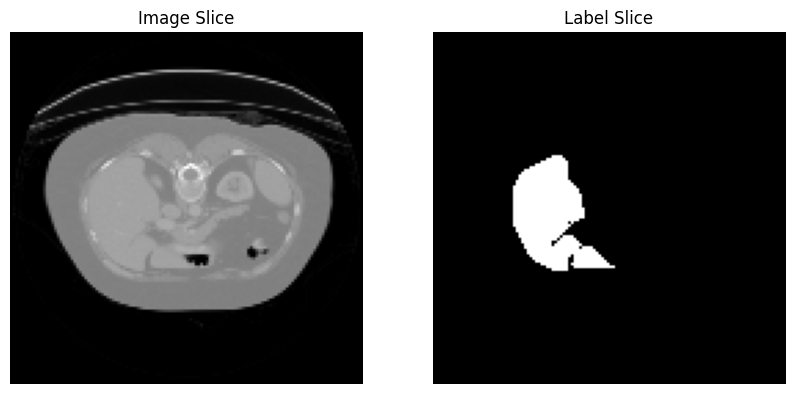

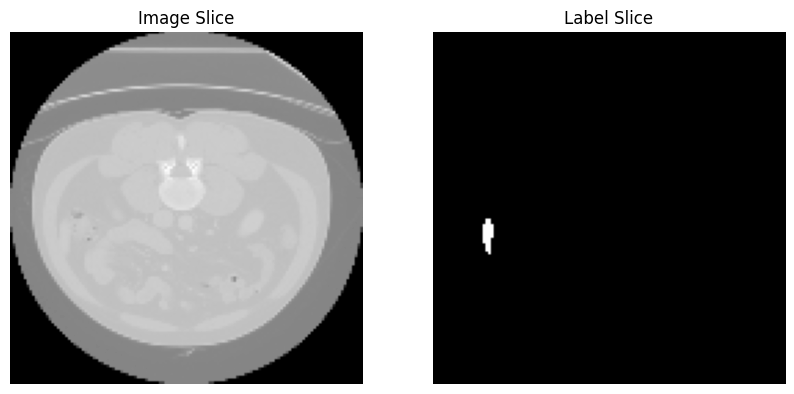

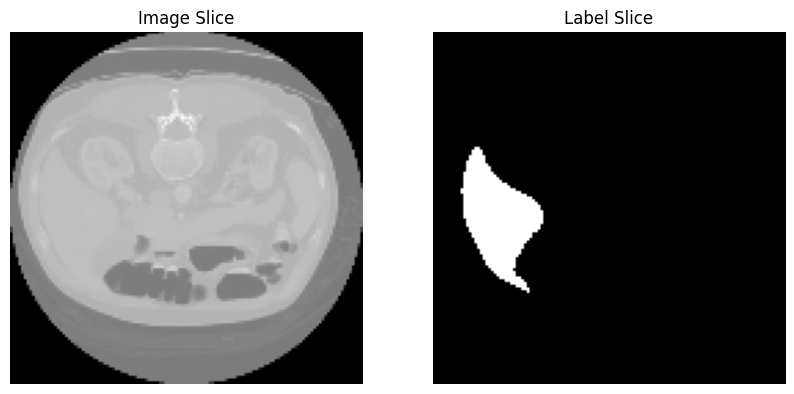

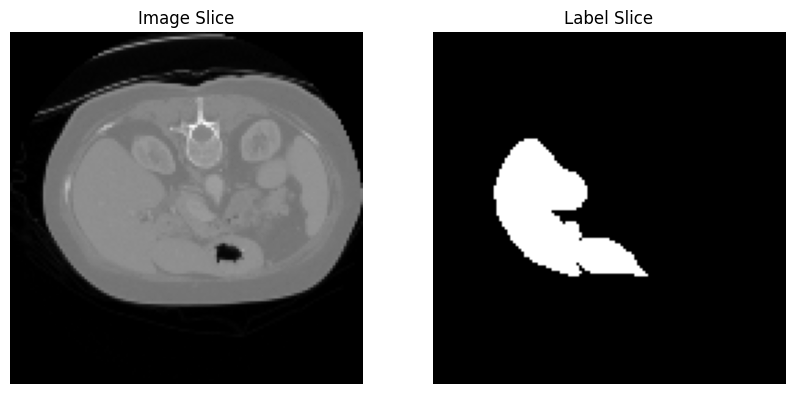

In [6]:
import random
import matplotlib.pyplot as plt

num_images_to_visualize = 4
random_image_indices = random.sample(range(len(data_X)), num_images_to_visualize)

for idx in random_image_indices:
    x = data_X[idx]
    y = data_Y[idx]

    while True:
      random_slice_index = random.randint(0, x.shape[0] - 1)
      if not np.all(y[random_slice_index] == 0):
        break

    slice_x = x[random_slice_index]
    slice_y = y[random_slice_index]

    # Plot the slice
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].imshow(slice_x, cmap='gray')
    axs[0].set_title('Image Slice')
    axs[0].axis('off')
    axs[1].imshow(slice_y, cmap='gray')
    axs[1].set_title('Label Slice')
    axs[1].axis('off')
    plt.show()

# Utils

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [8]:
def pad_to_shape(this, shp):
    if len(shp) == 4:
        pad = (0, shp[3] - this.shape[3], 0, shp[2] - this.shape[2])
    elif len(shp) == 5:
        pad = (0, shp[4] - this.shape[4], 0, shp[3] - this.shape[3], 0, shp[2] - this.shape[2])
    return F.pad(this, pad)

Write a function that computes the dice score between a batch of prediction and ground truths.

In [12]:
def dice_score(y_pred_bin, y_true):
    """
    Args:
        y_pred_bin: shape => (batch_size, 1, h, w)
        y_true: shape => (batch_size, 1, h, w)

    Returns:
        : shape => (batch_size, dice_score)
    """

    batch_size = y_pred_bin.shape[0]

    # Flatten the prediction and ground truth tensors
    y_pred_bin_flat = y_pred_bin.view(batch_size, -1)
    y_true_flat = y_true.view(batch_size, -1)


    # Compute the intersection and sum of prediction and ground truth tensors
    intersection = (y_pred_bin_flat * y_true_flat).sum(dim=1)
    pred_sum = y_pred_bin_flat.sum(dim=1)
    true_sum = y_true_flat.sum(dim=1)

    # Compute the Dice score
    dice_score = (2 * intersection) / (pred_sum + true_sum + 1e-8)


    return dice_score

# Part 1: 2D UNet

In this section we are going to use a 2D UNet to train a segmentation model.

## Part 1.1: Model Definition

First we need to implement the model architecture. The necessary modules are created in the init functions. Complete the forward method for the UNet model.

In [13]:
class UNet2D(nn.Module):

    def __init__(self, in_channels, out_channels, conv_depths=(16, 32, 64, 128, 256)):
        assert len(conv_depths) > 2, 'conv_depths must have at least 3 members'
        super(UNet2D, self).__init__()

        # defining encoder layers
        encoder_layers = []
        encoder_layers.append(First2D(in_channels, conv_depths[0], conv_depths[0]))
        encoder_layers.extend([Encoder2D(conv_depths[i], conv_depths[i + 1], conv_depths[i + 1])
                               for i in range(len(conv_depths)-2)])

        # defining decoder layers
        decoder_layers = []
        decoder_layers.extend([Decoder2D(2 * conv_depths[i + 1], 2 * conv_depths[i], 2 * conv_depths[i], conv_depths[i])
                               for i in reversed(range(len(conv_depths)-2))])
        decoder_layers.append(Last2D(conv_depths[1], conv_depths[0], out_channels))

        # encoder, center and decoder layers
        self.encoder_layers = nn.Sequential(*encoder_layers)
        self.center = Center2D(conv_depths[-2], conv_depths[-1], conv_depths[-1], conv_depths[-2])
        self.decoder_layers = nn.Sequential(*decoder_layers)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x, return_all=False):
        encoder_outputs = []

        # Forward pass through the encoder layers
        for encoder_layer in self.encoder_layers:
            x = encoder_layer(x)
            encoder_outputs.append(x)

        # Forward pass through the center layer
        x = self.center(x)


        # Forward pass through the decoder layers
        for i, decoder_layer in enumerate(self.decoder_layers):
            skip_connection = encoder_outputs[-i - 1]
            x = decoder_layer(torch.cat((x, skip_connection), 1))

        x = self.sigmoid(x)

        # If return_all is True, return the outputs from all decoder layers
        if return_all:
            return x, encoder_outputs

        # Otherwise, return the output from the last decoder layer
        return x

## Part 1.2: Dataset Definition

In [14]:
class Dataset2D(Dataset):
    def __init__(self, x, y, Normalization = False):

        self.Normalization = Normalization
        self.slices_x = []
        self.slices_y = []
        for i in range(x.shape[0]):
            for j in range(x.shape[1]):
                sx = x[i, j, :, :]
                sy = y[i, j, :, :]
                if sy.sum() > 0:
                    self.slices_x.append(sx)
                    self.slices_y.append(sy)

    def __len__(self):
        return len(self.slices_x) # number of samples


    def __getitem__(self, index): # sampling method. used by DataLoader.
        x = self.slices_x[index]
        y = self.slices_y[index]
        if self.Normalization:
            x = (x - x.min()) / (x.max() - x.min())
        return  np.expand_dims(x, axis=0), np.expand_dims(y, axis=0), index # we return the index as well for future use

## Part 1.3: Train

In [15]:
model = UNet2D(in_channels=1, out_channels=1)
model.to(device).float()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-1)
epochs = 50

In [16]:
train_loader = DataLoader(
    Dataset2D(train_X, train_Y, Normalization=True),
    batch_size=32,
    shuffle=True,
    num_workers=6
)

print('Train Loader Done')

valid_loader = DataLoader(
    Dataset2D(valid_X, valid_Y, Normalization=True),
    batch_size=32,
    shuffle=False,
    num_workers=6
)

print('Validation Loader Done')

samples_count = len(train_loader.dataset)
val_samples_count = len(valid_loader.dataset)

Train Loader Done
Validation Loader Done


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [17]:
for inputs, targets, _ in train_loader:
  print(targets.shape)
  break

torch.Size([32, 1, 128, 128])


The necesary components are created. Now write the training loop and train your model. Report validation results during training and save the training log in the notebook.

In [18]:
# Training loop
best_val_loss = 1e9
best_model = UNet2D(in_channels=1, out_channels=1)

for epoch in range(epochs):
    model.train()
    train_loss = 0
    train_dice = 0

    # Iterate over the training dataset
    for inputs, targets, _ in train_loader:
        inputs = inputs.to(device).float()
        targets = targets.to(device).float()

        # Forward pass
        outputs = model(inputs)
        indices =  torch.nonzero(targets.view(targets.shape[0], -1).any(dim=1)).squeeze()
        loss = 1 - dice_score(outputs[indices], targets[indices]).mean()

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_dice += dice_score(outputs[indices], targets[indices]).sum()
        train_loss += loss.item() * inputs.size(0)

    # Compute average training loss
    train_loss /= samples_count
    train_dice /= samples_count

    # Evaluation on validation set
    model.eval()
    val_loss = 0
    val_dice = 0

    # Disable gradient computation for validation
    with torch.no_grad():
        for inputs, targets, _ in valid_loader:
            inputs = inputs.to(device).float()
            targets = targets.to(device).float()

            # Forward pass
            outputs = model(inputs)
            indices =  torch.nonzero(targets.view(targets.shape[0], -1).any(dim=1)).squeeze()
            loss = 1 - dice_score(outputs[indices], targets[indices]).mean()
            val_loss += loss.item() * inputs.size(0)
            val_dice += dice_score(outputs[indices], targets[indices]).sum()

    # Compute average validation loss and accuracy
    val_loss /= val_samples_count
    val_dice /= val_samples_count

    if val_loss <= best_val_loss:
      best_val_loss = val_loss
      best_model.load_state_dict(model.state_dict())

    # Print training and validation results
    print(f"Epoch {epoch + 1}/{epochs}")
    print(f"Train Loss: {train_loss:.4f}")
    print(f"Train Dice: {train_dice:.4f}")
    print(f"Validation Loss: {val_loss:.4f}")
    print(f"Validation Dice: {val_dice:.4f}")
    print()


# Save the trained model
torch.save(best_model.state_dict(), "model_2d.pth")

Epoch 1/50
Train Loss: 0.6768
Train Dice: 0.3232
Validation Loss: 0.6787
Validation Dice: 0.3213

Epoch 2/50
Train Loss: 0.5215
Train Dice: 0.4785
Validation Loss: 0.8313
Validation Dice: 0.1687

Epoch 3/50
Train Loss: 0.4973
Train Dice: 0.5027
Validation Loss: 0.5156
Validation Dice: 0.4844

Epoch 4/50
Train Loss: 0.4793
Train Dice: 0.5207
Validation Loss: 0.5252
Validation Dice: 0.4748

Epoch 5/50
Train Loss: 0.4384
Train Dice: 0.5616
Validation Loss: 0.5520
Validation Dice: 0.4480

Epoch 6/50
Train Loss: 0.4171
Train Dice: 0.5829
Validation Loss: 0.5542
Validation Dice: 0.4458

Epoch 7/50
Train Loss: 0.4251
Train Dice: 0.5749
Validation Loss: 0.5420
Validation Dice: 0.4580

Epoch 8/50
Train Loss: 0.4099
Train Dice: 0.5901
Validation Loss: 0.7756
Validation Dice: 0.2244

Epoch 9/50
Train Loss: 0.3919
Train Dice: 0.6081
Validation Loss: 0.6401
Validation Dice: 0.3599

Epoch 10/50
Train Loss: 0.3750
Train Dice: 0.6250
Validation Loss: 0.5817
Validation Dice: 0.4183

Epoch 11/50
Train L

# Part 2: 3D UNet

Now we want to use a 3D model and see if we can get better results. Complete the specified parts and train the model.

## Part 2.1: Model Definition

In [19]:
class UNet3D(nn.Module):
    def __init__(self, in_channels, out_channels, conv_depths=(16, 32, 64, 128, 256)):
        assert len(conv_depths) > 2, 'conv_depths must have at least 3 members'

        super(UNet3D, self).__init__()

        # defining encoder layers
        encoder_layers = []
        encoder_layers.append(First3D(in_channels, conv_depths[0], conv_depths[0]))
        encoder_layers.extend([Encoder3D(conv_depths[i], conv_depths[i + 1], conv_depths[i + 1])
                               for i in range(len(conv_depths)-2)])

        # defining decoder layers
        decoder_layers = []
        decoder_layers.extend([Decoder3D(2 * conv_depths[i + 1], 2 * conv_depths[i], 2 * conv_depths[i], conv_depths[i])
                               for i in reversed(range(len(conv_depths)-2))])
        decoder_layers.append(Last3D(conv_depths[1], conv_depths[0], out_channels))

        # encoder, center and decoder layers
        self.encoder_layers = nn.Sequential(*encoder_layers)
        self.center = Center3D(conv_depths[-2], conv_depths[-1], conv_depths[-1], conv_depths[-2])
        self.decoder_layers = nn.Sequential(*decoder_layers)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x, return_all=False):

        encoder_outputs = []

        # Forward pass through the encoder layers
        for encoder_layer in self.encoder_layers:
            x = encoder_layer(x)
            encoder_outputs.append(x)

        # Forward pass through the center layer
        x = self.center(x)

        # Forward pass through the decoder layers
        for i, decoder_layer in enumerate(self.decoder_layers):
            skip_connection = encoder_outputs[-i - 1]
            x = decoder_layer(torch.cat((x, skip_connection), 1))

        x = self.sigmoid(x)

        # If return_all is True, return the outputs from all decoder layers
        if return_all:
            return x, encoder_outputs

        # Otherwise, return the output from the last decoder layer
        return x

## Part 2.2: Dataset Definition

In [20]:
class Dataset3D(Dataset):
    def __init__(self, x, y, Normalization = False):

        self.Normalization = Normalization
        self.x = x
        self.y = y

    def __len__(self):
        return len(self.x) # number of samples


    def __getitem__(self, index): # sampling method. used by DataLoader.
        x = self.x[index]
        y = self.y[index]
        if self.Normalization:
            x = (x - x.min()) / (x.max() - x.min())
        return np.expand_dims(x, axis=0), np.expand_dims(y, axis=0), index # we return the index as well for future use

## Part 2.3: Train

In [21]:
model = UNet3D(in_channels=1, out_channels=1)
model = model.to(device).float()
model.train()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
epochs = 50

In [22]:
train_loader = DataLoader(
    Dataset3D(train_X, train_Y, Normalization=True),
    batch_size=1,
    shuffle=True,
    num_workers=6
)

print('Train Loader Done')

valid_loader = DataLoader(
    Dataset3D(valid_X, valid_Y, Normalization=True),
    batch_size=1,
    shuffle=False,
    num_workers=6
)

print('Validation Loader Done')

samples_count = len(train_loader.dataset)
val_samples_count = len(valid_loader.dataset)

Train Loader Done
Validation Loader Done


In [23]:
for inputs, targets, _ in train_loader:
  print(targets.shape)
  break

torch.Size([1, 1, 208, 128, 128])


In [24]:
# Training loop
best_val_loss = 1e9
best_model = UNet3D(in_channels=1, out_channels=1)
for epoch in range(epochs):
    model.train()
    train_loss = 0
    train_dice = 0

    # Iterate over the training dataset
    for inputs, targets, _ in train_loader:
        inputs = inputs.to(device).float()
        targets = targets.to(device).float()


        # Forward pass
        outputs = model(inputs)
        #print(outputs.shape)

        reshaped_tensor = targets.view(1, 1, 208, -1)
        indices = torch.any(reshaped_tensor != 0, dim=3).nonzero()

        dice = dice_score(outputs[indices[:, 0], indices[:, 1], indices[:, 2], :, :].unsqueeze(dim=1), targets[indices[:, 0], indices[:, 1], indices[:, 2], :, :].unsqueeze(dim=1)).mean()
        loss = 1 - dice

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_dice += dice
        train_loss += loss.item()

    # Compute average training loss
    train_loss /= samples_count
    train_dice /= samples_count

    # Evaluation on validation set
    model.eval()
    val_loss = 0
    val_dice = 0

    # Disable gradient computation for validation
    with torch.no_grad():
        for inputs, targets, _ in valid_loader:
            inputs = inputs.to(device).float()
            targets = targets.to(device).float()


            reshaped_tensor = targets.view(1, 1, 208, -1)
            indices = torch.any(reshaped_tensor != 0, dim=3).nonzero()


            # Forward pass
            outputs = model(inputs)

            dice = dice_score(outputs[indices[:, 0], indices[:, 1], indices[:, 2], :, :].unsqueeze(dim=1), targets[indices[:, 0], indices[:, 1], indices[:, 2], :, :].unsqueeze(dim=1)).mean()
            loss = 1 - dice
            val_loss += loss.item()
            val_dice += dice

    # Compute average validation loss and accuracy
    val_loss /= val_samples_count
    val_dice /= val_samples_count

    if val_loss <= best_val_loss:
      best_val_loss = val_loss
      best_model.load_state_dict(model.state_dict())

    # Print training and validation results
    print(f"Epoch {epoch + 1}/{epochs}")
    print(f"Train Loss: {train_loss:.4f}")
    print(f"Train Dice: {train_dice:.4f}")
    print(f"Validation Loss: {val_loss:.4f}")
    print(f"Validation Dice: {val_dice:.4f}")
    print()


# Save the trained model
torch.save(best_model.state_dict(), "model_3d.pth")

Epoch 1/50
Train Loss: 0.7699
Train Dice: 0.2301
Validation Loss: 0.7158
Validation Dice: 0.2842

Epoch 2/50
Train Loss: 0.6603
Train Dice: 0.3397
Validation Loss: 0.6089
Validation Dice: 0.3911

Epoch 3/50
Train Loss: 0.5892
Train Dice: 0.4108
Validation Loss: 0.5519
Validation Dice: 0.4481

Epoch 4/50
Train Loss: 0.5200
Train Dice: 0.4800
Validation Loss: 0.4775
Validation Dice: 0.5225

Epoch 5/50
Train Loss: 0.4553
Train Dice: 0.5447
Validation Loss: 0.3924
Validation Dice: 0.6076

Epoch 6/50
Train Loss: 0.4300
Train Dice: 0.5700
Validation Loss: 0.3847
Validation Dice: 0.6153

Epoch 7/50
Train Loss: 0.3995
Train Dice: 0.6005
Validation Loss: 0.4194
Validation Dice: 0.5806

Epoch 8/50
Train Loss: 0.3844
Train Dice: 0.6156
Validation Loss: 0.3752
Validation Dice: 0.6248

Epoch 9/50
Train Loss: 0.3251
Train Dice: 0.6749
Validation Loss: 0.3317
Validation Dice: 0.6683

Epoch 10/50
Train Loss: 0.2949
Train Dice: 0.7051
Validation Loss: 0.3000
Validation Dice: 0.7000

Epoch 11/50
Train L

# Visualization

In the final section visualize segmentation masks for a few random slices for both 2D and 3D model

In [25]:
import matplotlib.pyplot as plt
import random

## 2D Model

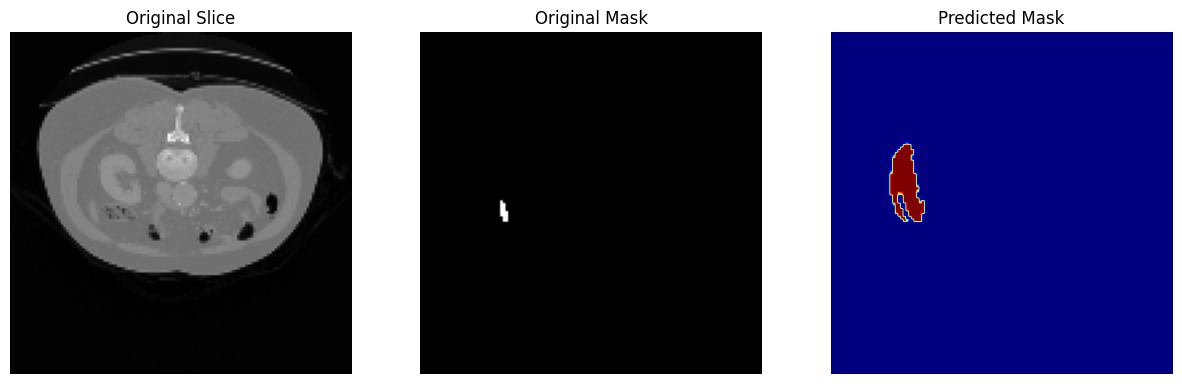

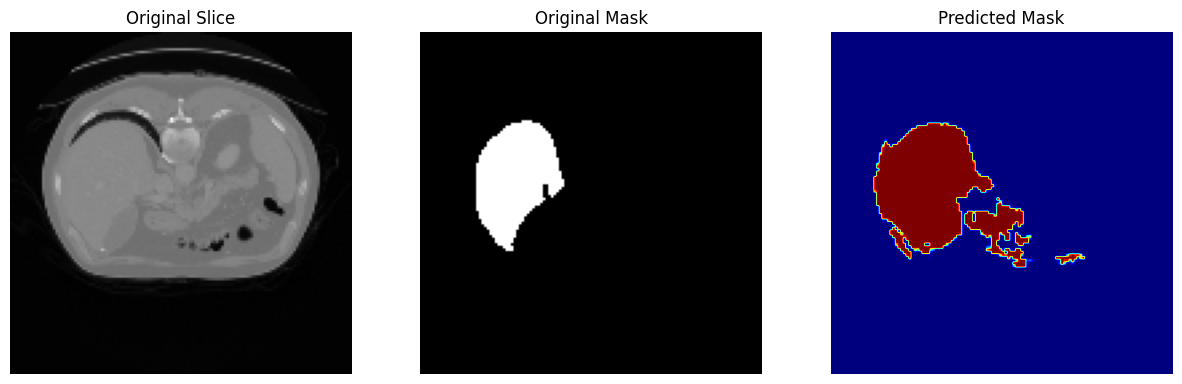

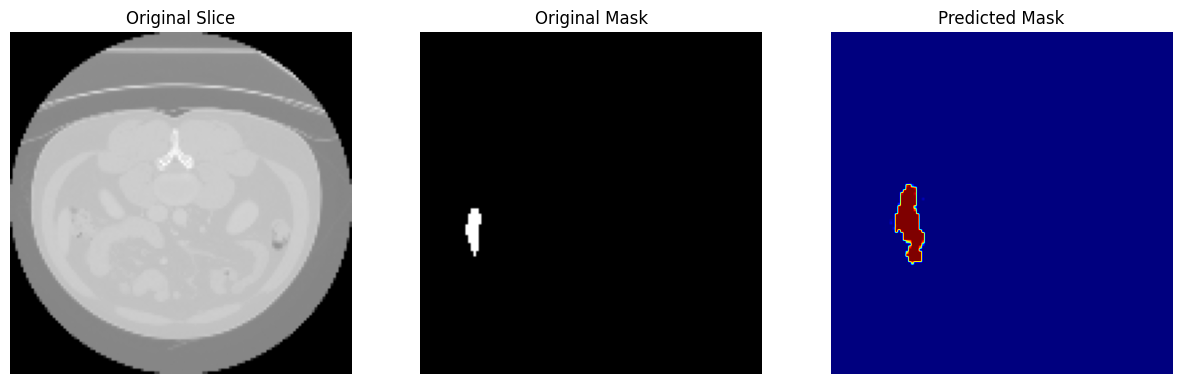

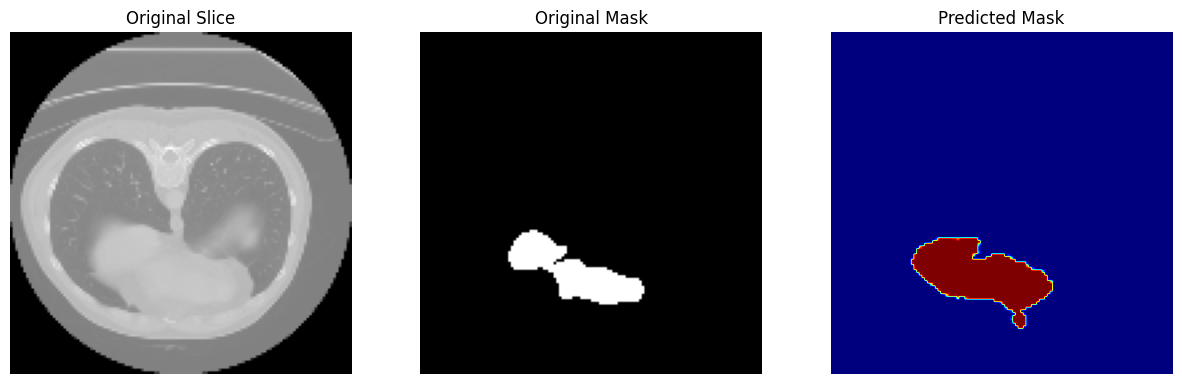

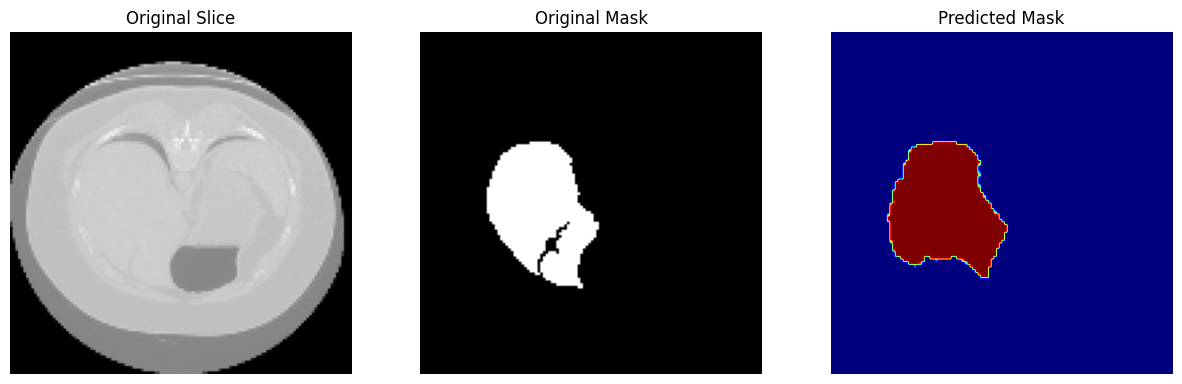

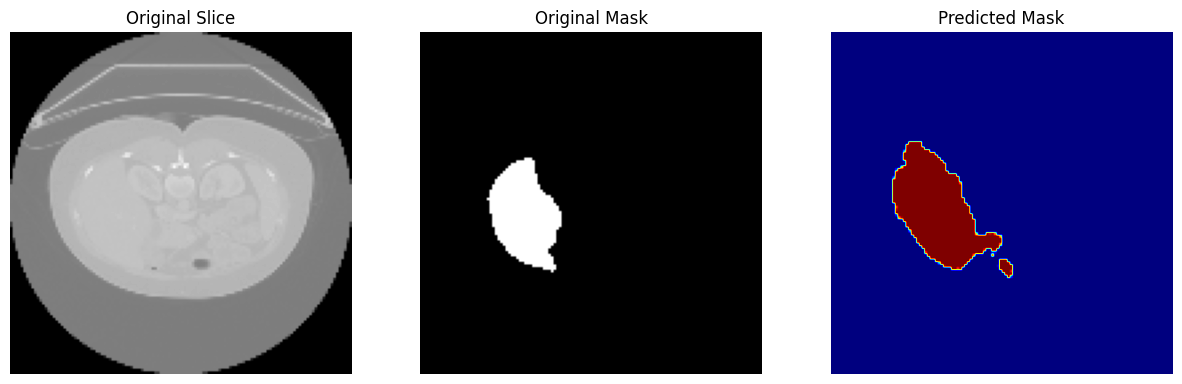

In [26]:
# Assuming you have the original slices and predicted masks as numpy arrays
# For 2D model, assuming you have 'original_slices' and 'predicted_masks'
# For 3D model, assuming you have 'original_volumes' and 'predicted_masks'

# Visualize random slices for 2D model
num_slices = 5  # Number of random slices to visualize

model_2d = UNet2D(in_channels=1, out_channels=1)
state_dict = torch.load('/content/model_2d.pth')

# Load the state dictionary into the model
model_2d.load_state_dict(state_dict)

# Ensure the model is in evaluation mode
model_2d.eval()

valid_loader = DataLoader(
    Dataset2D(valid_X, valid_Y, Normalization=True),
    batch_size=32,
    shuffle=False,
    num_workers=6
)

i = 0

for inputs, targets, _ in valid_loader:
    original_slice = inputs[0]
    target = targets[0]
    predicted_mask = model_2d(inputs.float()).detach()[0].squeeze(dim=0)

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].imshow(original_slice.squeeze(dim=0), cmap='gray')
    axes[0].set_title('Original Slice')
    axes[0].axis('off')
    axes[1].imshow(target.squeeze(dim=0), cmap='gray')  # Assuming jet colormap for the mask
    axes[1].set_title('Original Mask')
    axes[1].axis('off')
    axes[2].imshow(predicted_mask, cmap='jet')  # Assuming jet colormap for the mask
    axes[2].set_title('Predicted Mask')
    axes[2].axis('off')

    plt.show()
    i += 1
    if i > 5:
      break

### 3D Model

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


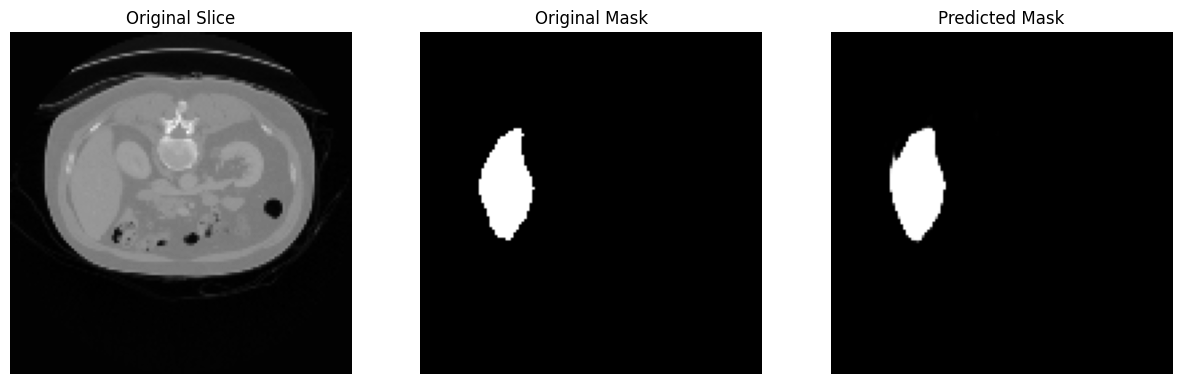

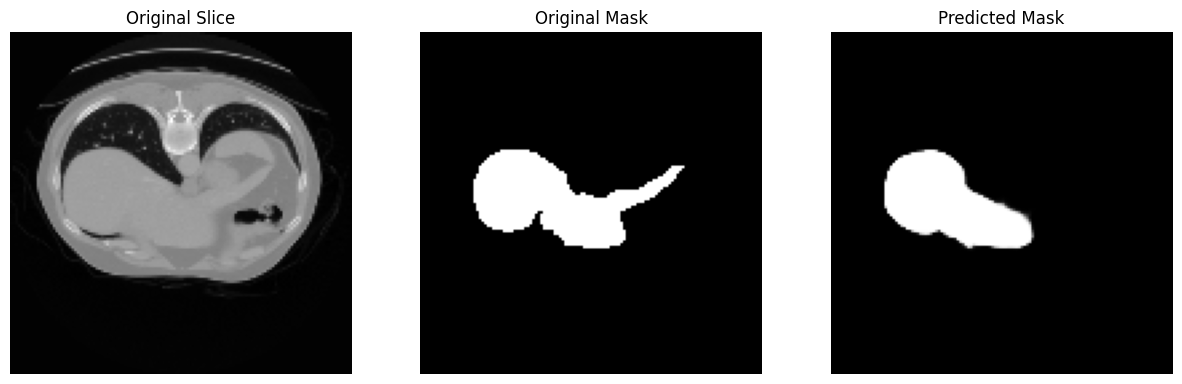

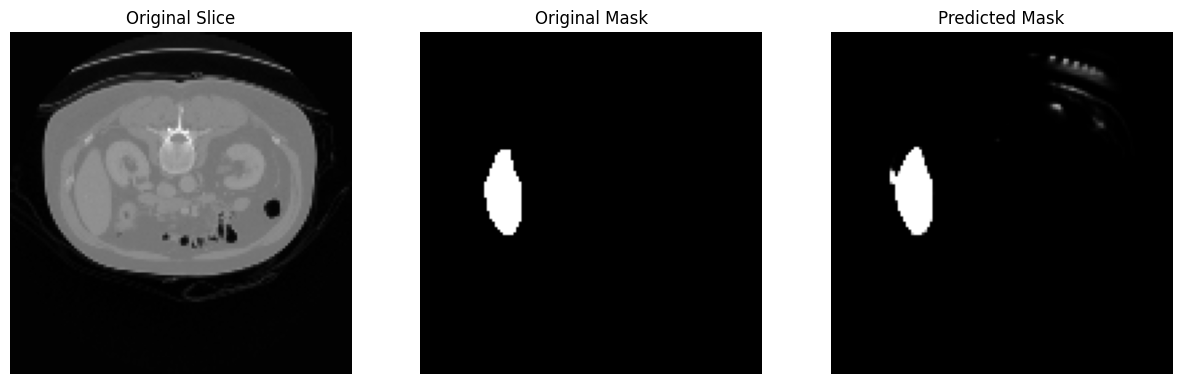

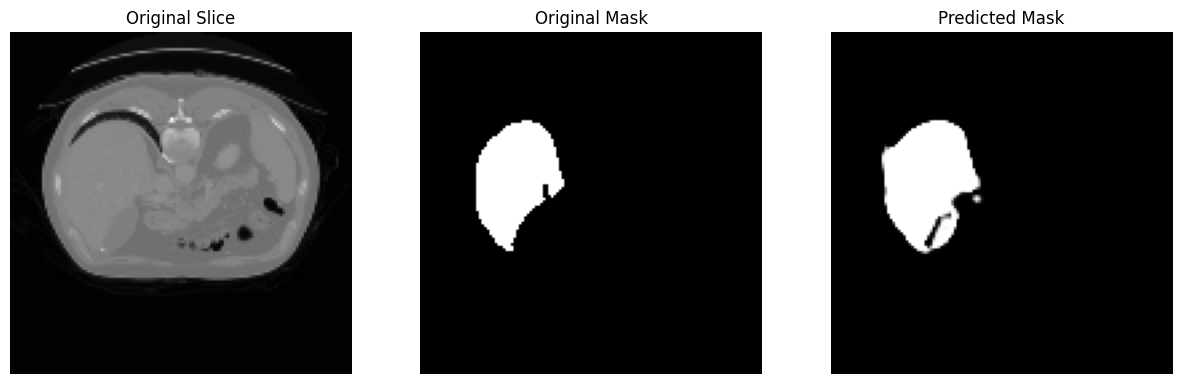

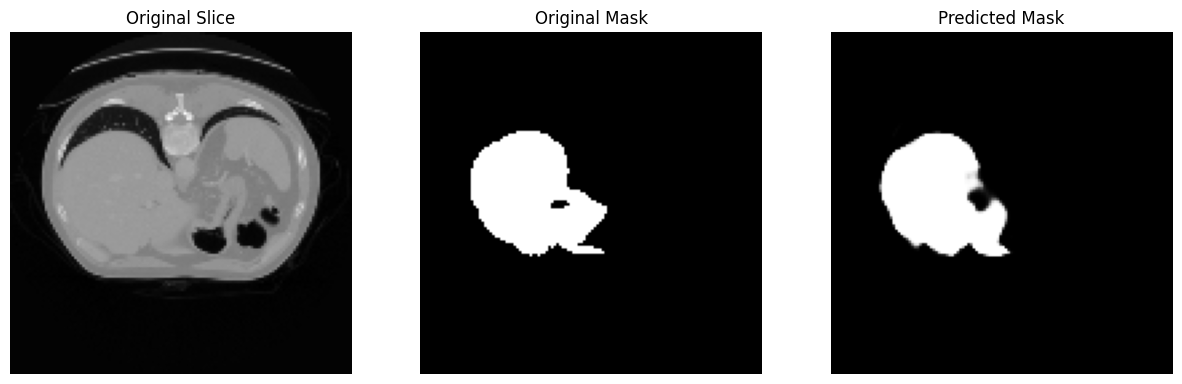

In [31]:
model_3d = UNet3D(in_channels=1, out_channels=1)
state_dict = torch.load('/content/model_3d.pth')

# Load the state dictionary into the model
model_3d.load_state_dict(state_dict)

# Ensure the model is in evaluation mode
model_3d.eval()

valid_loader = DataLoader(
    Dataset3D(valid_X, valid_Y, Normalization=True),
    batch_size=1,
    shuffle=False,
    num_workers=6
)

for inputs, targets, _ in valid_loader:

    reshaped_tensor = targets.view(1, 1, 208, -1)
    indices = torch.any(reshaped_tensor != 0, dim=3).nonzero()
    outs = model_3d(inputs.float())

    for j in range(5):
      i = random.randint(0, len(indices))
      original_slice = inputs[indices[:, 0], indices[:, 1], indices[:, 2], :, :].unsqueeze(dim=1)[i]
      target = targets[indices[:, 0], indices[:, 1], indices[:, 2], :, :].unsqueeze(dim=1)[i]
      predicted_mask = outs[indices[:, 0], indices[:, 1], indices[:, 2], :, :].unsqueeze(dim=1).detach()[i]

      fig, axes = plt.subplots(1, 3, figsize=(15, 5))
      axes[0].imshow(original_slice.squeeze(dim=0), cmap='gray')
      axes[0].set_title('Original Slice')
      axes[0].axis('off')
      axes[1].imshow(target.squeeze(dim=0), cmap='gray')  # Assuming jet colormap for the mask
      axes[1].set_title('Original Mask')
      axes[1].axis('off')
      axes[2].imshow(predicted_mask.squeeze(dim=0), cmap='gray')  # Assuming jet colormap for the mask
      axes[2].set_title('Predicted Mask')
      axes[2].axis('off')

      plt.show()

    break

# Why 3D Model Acts Much Better?

## Answer

The 2D model processes each slice of a 3D image independently, treating them as separate 2D images. This approach ignores the volumetric nature of the data and does not account for the contextual information provided by the neighboring slices. Consequently, the 2D model may struggle to capture the full spatial relationships and context across the entire 3D volume, leading to lower accuracy.
But in contrast, the 3D model operates on the entire 3D volume simultaneously, considering the spatial relationships and context within and across slices. By incorporating the volumetric information, the 3D model can capture more comprehensive features and contextual dependencies, resulting in improved accuracy.